In [1]:
#!pip install finta

In [2]:
# needed for processing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

#needed for openai gym environment
import gym
import gym_anytrading

# needed for reinforcement learning 
from stable_baselines3.common.vec_env import DummyVecEnv #wrapper vec
from stable_baselines3 import PPO


from finta import TA
from gym_anytrading.envs import StocksEnv

In [3]:
googl_df = pd.read_csv('GOOGL.csv')

In [4]:
# I would not need dividends and stock splits so this can be dropped
googl_df = googl_df.drop(columns=['Dividends', 'Stock Splits'])

In [5]:
googl_df['N_date'] = googl_df['Date'].str[:10]
googl_df['N_date'] = pd.to_datetime(googl_df['N_date'])
googl_df = googl_df.drop(columns=['Date'])
# gym training environment expects the date to be index, so need to change it
googl_df.rename(columns = {'N_date':'Date'}, inplace=True)
googl_df.set_index('Date', inplace=True)
googl_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19,2.502503,2.604104,2.401401,2.511011,893181924
2004-08-20,2.527778,2.729730,2.515015,2.710460,456686856
2004-08-23,2.771522,2.839840,2.728979,2.737738,365122512
2004-08-24,2.783784,2.792793,2.591842,2.624374,304946748
2004-08-25,2.626627,2.702703,2.599600,2.652653,183772044


In [6]:
googl_df['SMA'] = TA.SMA(googl_df,50) 
googl_df['ROC'] = TA.ROC(googl_df) 
googl_df['RSI'] = TA.RSI(googl_df)
googl_df['STOCH'] = TA.STOCH(googl_df)
#'ROC', 'RSI', 'STOCH'
googl_df.fillna(0,inplace=True)

In [7]:
df = googl_df

In [8]:
# modified from the anytrading githiub page
def add_signals(googl_env):
    start = googl_env.frame_bound[0] - googl_env.window_size #getting start index, same goes for end
    end = googl_env.frame_bound[1]
    prices = googl_env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = googl_env.df.loc[: , ['Low', 'Volume', 'STOCH','RSI','SMA','ROC']].to_numpy()[start:end]
    return prices, signal_features

In [9]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    


In [10]:
googl_env2 = MyCustomEnv(df=df, window_size=10, frame_bound=(700,3500))

In [11]:
googl_maker = lambda: googl_env2
# can try this with other types of enivornment not just the DummyVec
googl_env = DummyVecEnv([googl_maker])

In [12]:
ppo_model = PPO('MlpPolicy', googl_env, verbose=1)
ppo_model.learn(total_timesteps=25000)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1916 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1137         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0058285734 |
|    clip_fraction        | 0.019        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.687       |
|    explained_variance   | -0.278       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.226        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00262     |
|    value_loss           | 0.455        |
------------------------------------------

------------------------------------------
| time/                   |              |
|    fps                  | 921          |
|    iterations           | 13           |
|    time_elapsed         | 28           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0077883103 |
|    clip_fraction        | 0.0517       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.586       |
|    explained_variance   | 0.0219       |
|    learning_rate        | 0.0003       |
|    loss                 | 0.17         |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00748     |
|    value_loss           | 0.522        |
------------------------------------------


info {'total_reward': 4.107498168945284, 'total_profit': 0.9203856636299821, 'position': 1}


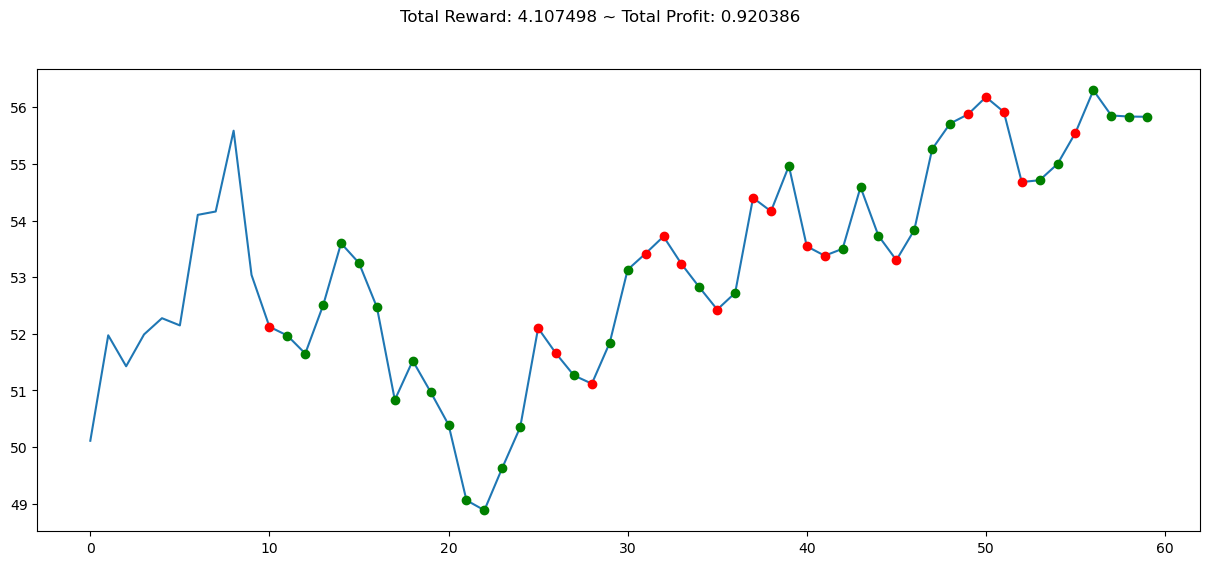

In [13]:
googl_env = MyCustomEnv(df=df, window_size=10, frame_bound=(3600,3650))
obs = googl_env.reset()
while True:
    obs = obs[np.newaxis, ...] #reshaping our observation so it can work with a non-vectorized environment. 
    action, _states = ppo_model.predict(obs) # rather than taking random actions, we use our model to predict what action it should take: buy,sell,hold
    obs,rewards, done, info = googl_env.step(action)
    if done:
        print('info', info)
        break
indicators = info['total_profit']
plt.figure(figsize=(15,6))
plt.cla()
googl_env.render_all()
plt.show()

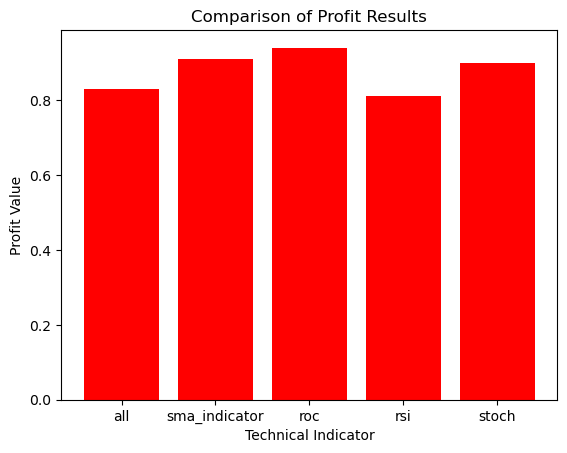

In [14]:
# the values here were one run of the code, done so I could visualise it. 
all_indicators = 0.83
sma_indicator = 0.91 
roc_indicator = 0.94 
rsi_indicator = 0.81
stoch_indicator = 0.90
x = ['all', 'sma_indicator', 'roc', 'rsi', 'stoch']
y = [all_indicators, sma_indicator,roc_indicator,rsi_indicator, stoch_indicator]
colors = ['green' if result > 1 else 'red' for result in y ]
plt.bar(x, y, color=colors)
plt.title('Comparison of Profit Results')
plt.xlabel('Technical Indicator')
plt.ylabel('Profit Value')
plt.show()